# Dataset Balancing for Classification

In this notebook, we'll explore various techniques to handle imbalanced datasets for classification problems. Imbalanced datasets occur when one class significantly outnumbers other classes, which can lead to biased models that perform poorly on minority classes.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression

# For resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 1. Understanding Class Imbalance

Class imbalance occurs when one class (usually the majority class) has significantly more instances than another class (the minority class). This is common in many real-world scenarios:

- Fraud detection (few fraudulent transactions among many legitimate ones)
- Medical diagnosis (few positive cases among many negative ones)
- Spam detection (spam emails vs. legitimate emails)
- Churn prediction (customers who leave vs. those who stay)

Problems with imbalanced datasets:
- Models tend to learn a bias towards the majority class
- Standard accuracy metrics can be misleading
- The minority class, which is often the class of interest, may be poorly predicted

## 2. Creating a Sample Imbalanced Dataset

Let's create a synthetic imbalanced dataset to work with.

Class distribution:
target
0    89591
1    10409
Name: count, dtype: int64
Class 0: 89.59%
Class 1: 10.41%


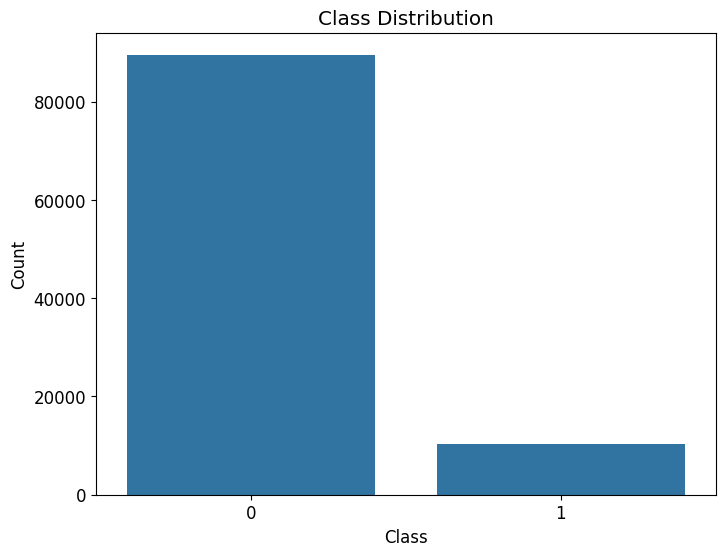

In [2]:
# Create an imbalanced dataset with 90% samples in class 0 and 10% in class 1
X, y = make_classification(
    n_samples=100000, 
    n_features=10,
    n_informative=5, 
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.9, 0.1],  # Class distribution: 90% class 0, 10% class 1
    random_state=42
)

# Convert to DataFrame for easier manipulation
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Check class distribution
class_counts = df['target'].value_counts()
print(f"Class distribution:\n{class_counts}")
print(f"Class 0: {class_counts[0] / len(df) * 100:.2f}%")
print(f"Class 1: {class_counts[1] / len(df) * 100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [3]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Probability predictions (for ROC curve)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Predicted 0', 'Predicted 1'],
               yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    # Plot both curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.legend(loc="lower right")
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, label=f'PR curve (area = {pr_auc:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

Let's split our data into training and testing sets with a stratified approach and see how a baseline model performs on our imbalanced dataset.

Training set class distribution:
target
0    62714
1     7286
Name: count, dtype: int64
Testing set class distribution:
target
0    26877
1     3123
Name: count, dtype: int64

Baseline (Imbalanced) - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     26877
           1       0.84      0.67      0.75      3123

    accuracy                           0.95     30000
   macro avg       0.90      0.83      0.86     30000
weighted avg       0.95      0.95      0.95     30000



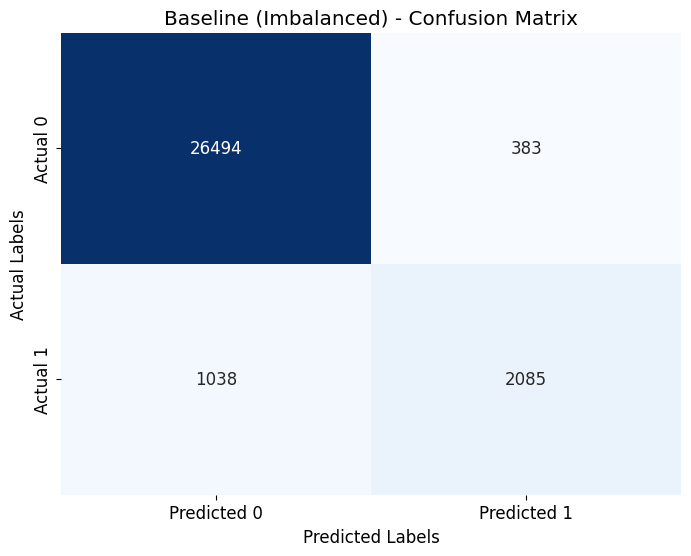

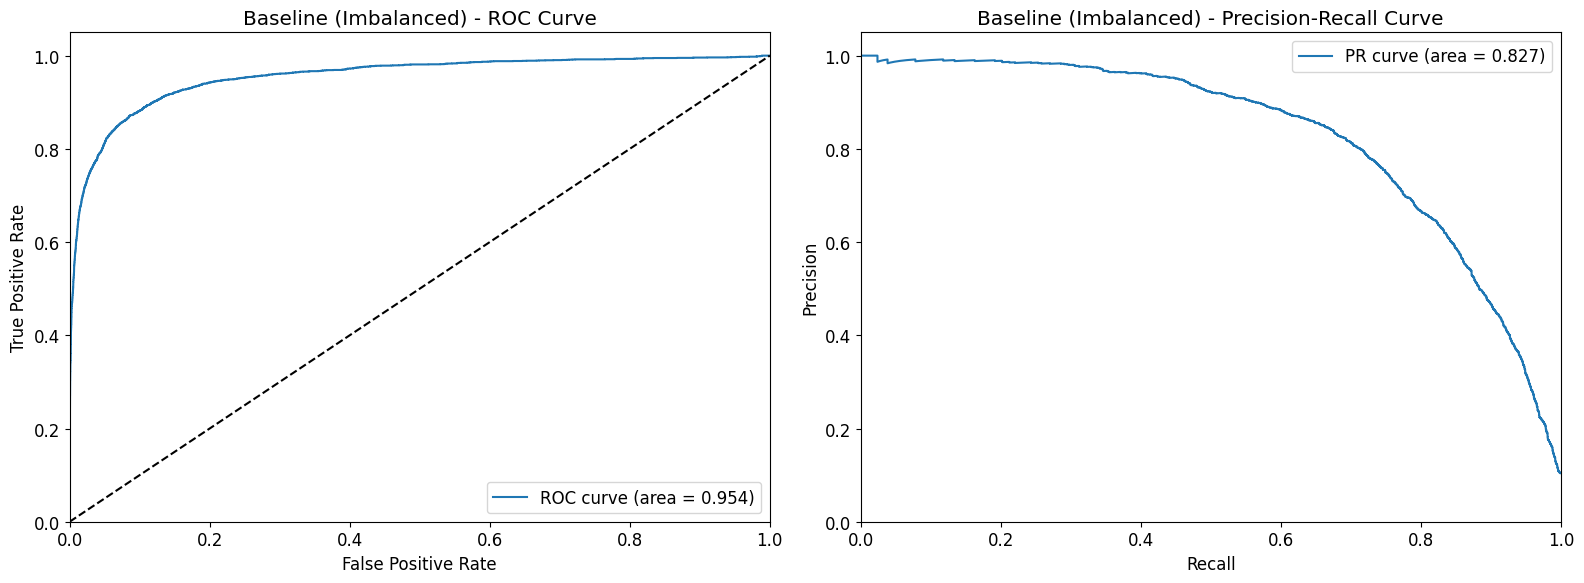

In [4]:
# Split the data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution in train and test sets
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")

# Train a baseline logistic regression model without any balancing
baseline_model = LogisticRegression(random_state=42)
baseline_results = evaluate_model(baseline_model, X_train, X_test, y_train, y_test, "Baseline (Imbalanced)")

## 3. Resampling Techniques

### 3.1 Undersampling

Undersampling reduces the number of instances in the majority class to match the minority class. This can help balance the dataset but may lead to information loss.

After undersampling - Training set class distribution:
target
0    7286
1    7286
Name: count, dtype: int64

Undersampling - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.90      0.64      3123

    accuracy                           0.90     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.90      0.91     30000



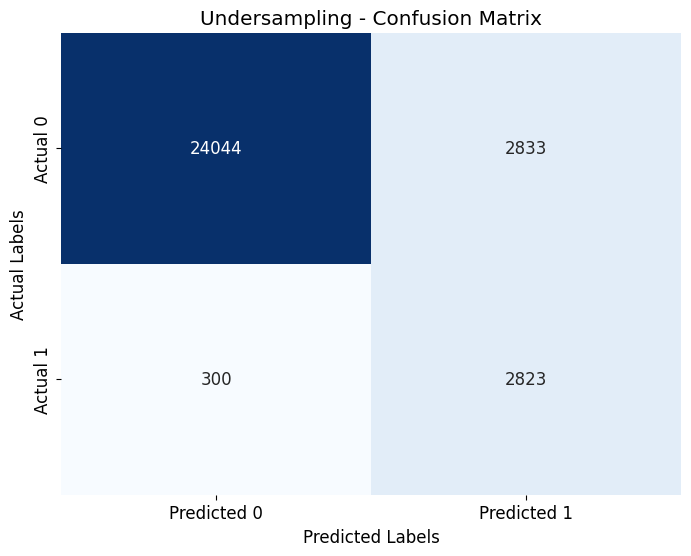

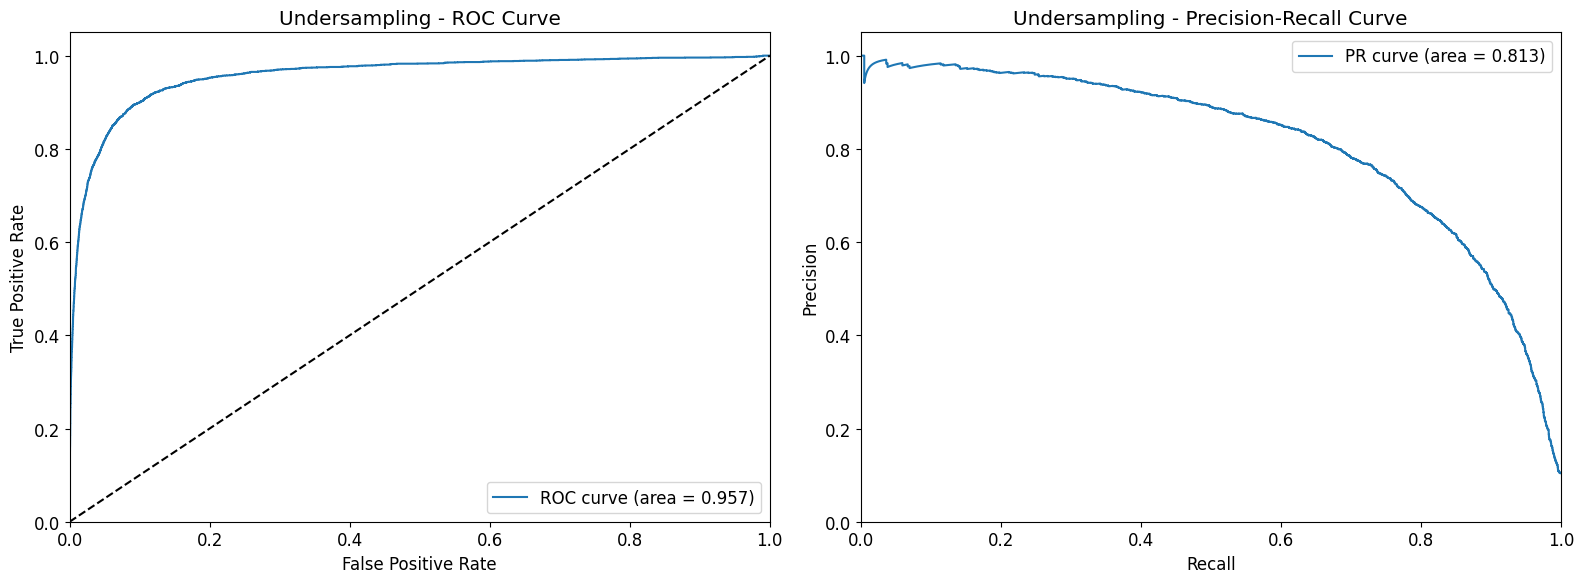

In [5]:
# Apply random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"After undersampling - Training set class distribution:\n{pd.Series(y_train_under).value_counts()}")

# Train a model on the undersampled data
undersample_model = LogisticRegression(random_state=42)
undersample_results = evaluate_model(undersample_model, X_train_under, X_test, y_train_under, y_test, "Undersampling")

### 3.2 Oversampling

Oversampling increases the number of instances in the minority class by duplicating existing samples. This preserves all majority class information but may lead to overfitting.

After oversampling - Training set class distribution:
target
0    62714
1    62714
Name: count, dtype: int64

Oversampling - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.91      0.64      3123

    accuracy                           0.89     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.89      0.91     30000



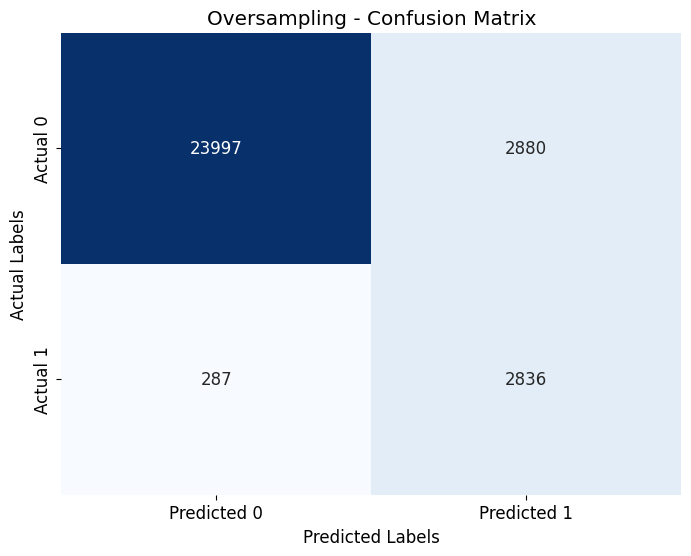

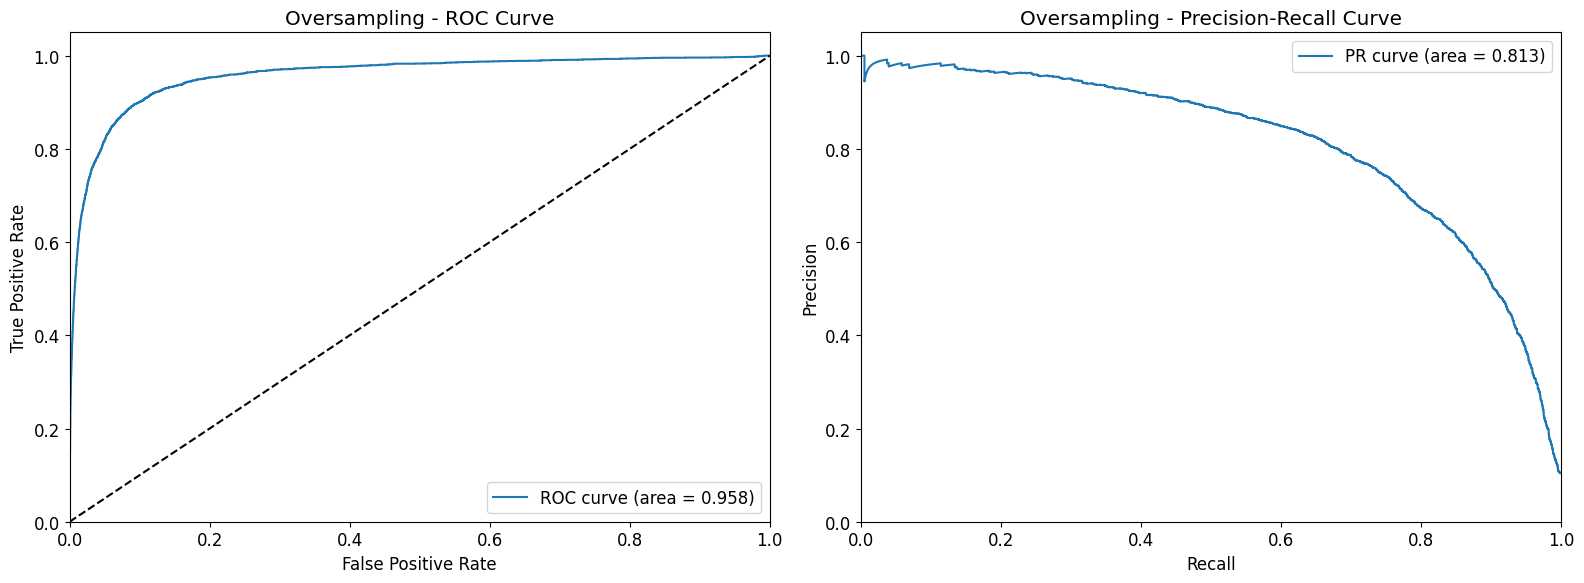

In [6]:
# Apply random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"After oversampling - Training set class distribution:\n{pd.Series(y_train_over).value_counts()}")

# Train a model on the oversampled data
oversample_model = LogisticRegression(random_state=42)
oversample_results = evaluate_model(oversample_model, X_train_over, X_test, y_train_over, y_test, "Oversampling")

### 3.3 SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE generates synthetic samples for the minority class by interpolating between existing minority samples. This reduces overfitting compared to simple oversampling.

After SMOTE - Training set class distribution:
target
0    62714
1    62714
Name: count, dtype: int64

SMOTE - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     26877
           1       0.50      0.90      0.65      3123

    accuracy                           0.90     30000
   macro avg       0.75      0.90      0.79     30000
weighted avg       0.94      0.90      0.91     30000



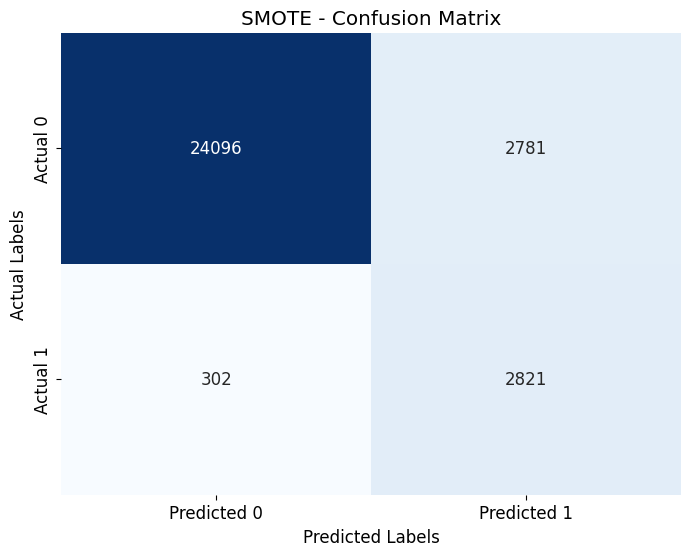

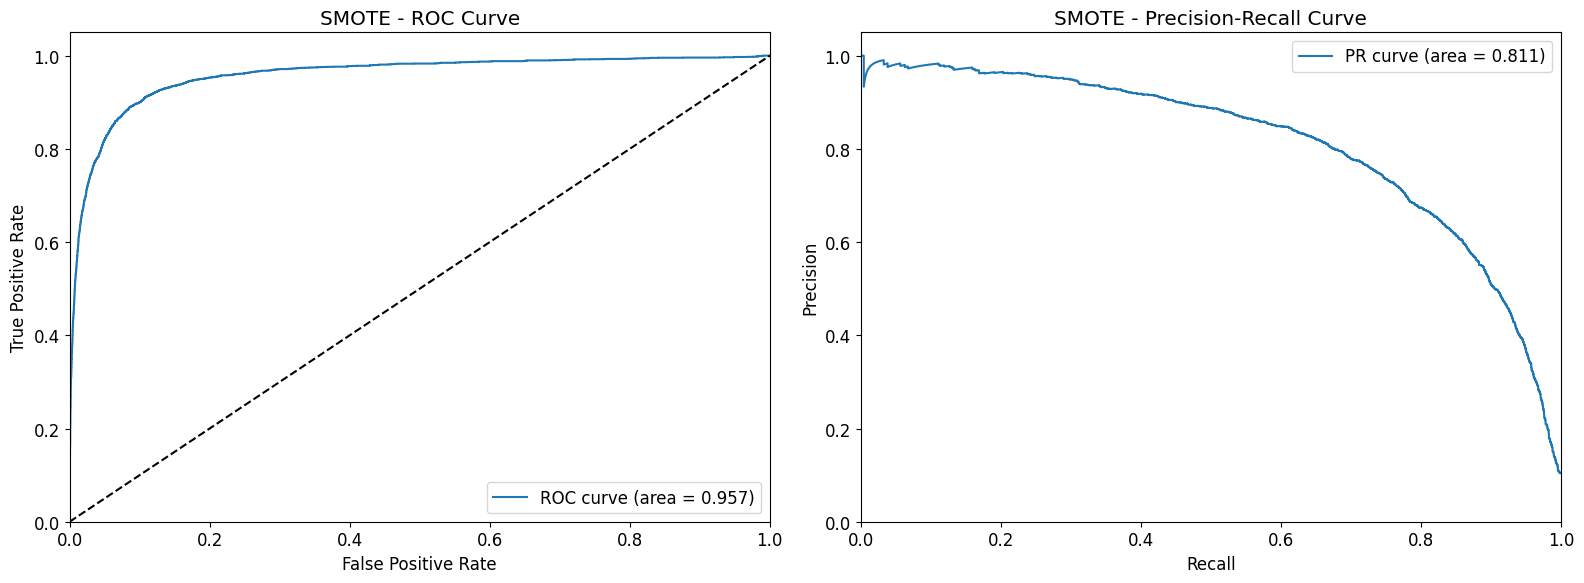

In [7]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"After SMOTE - Training set class distribution:\n{pd.Series(y_train_smote).value_counts()}")

# Train a model on the SMOTE data
smote_model = LogisticRegression(random_state=42)
smote_results = evaluate_model(smote_model, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")

## 4. Algorithm-level Approaches

### 4.1 Class Weights

Many machine learning algorithms allow you to assign different weights to classes, increasing the importance of the minority class.


Class Weights - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.91      0.64      3123

    accuracy                           0.89     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.89      0.91     30000



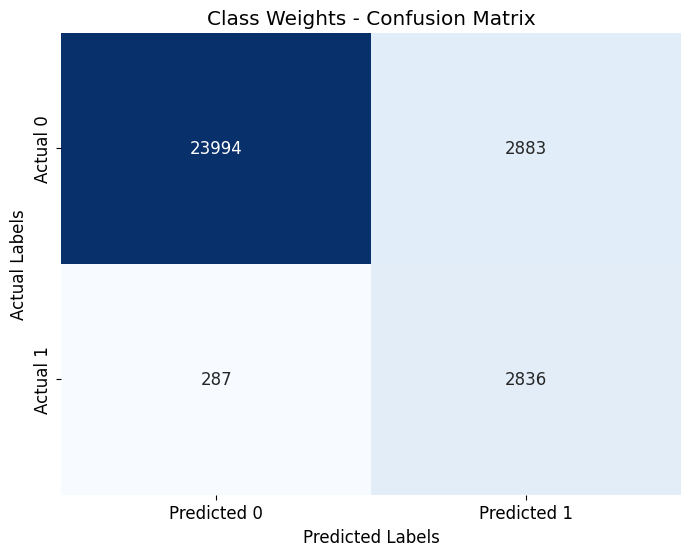

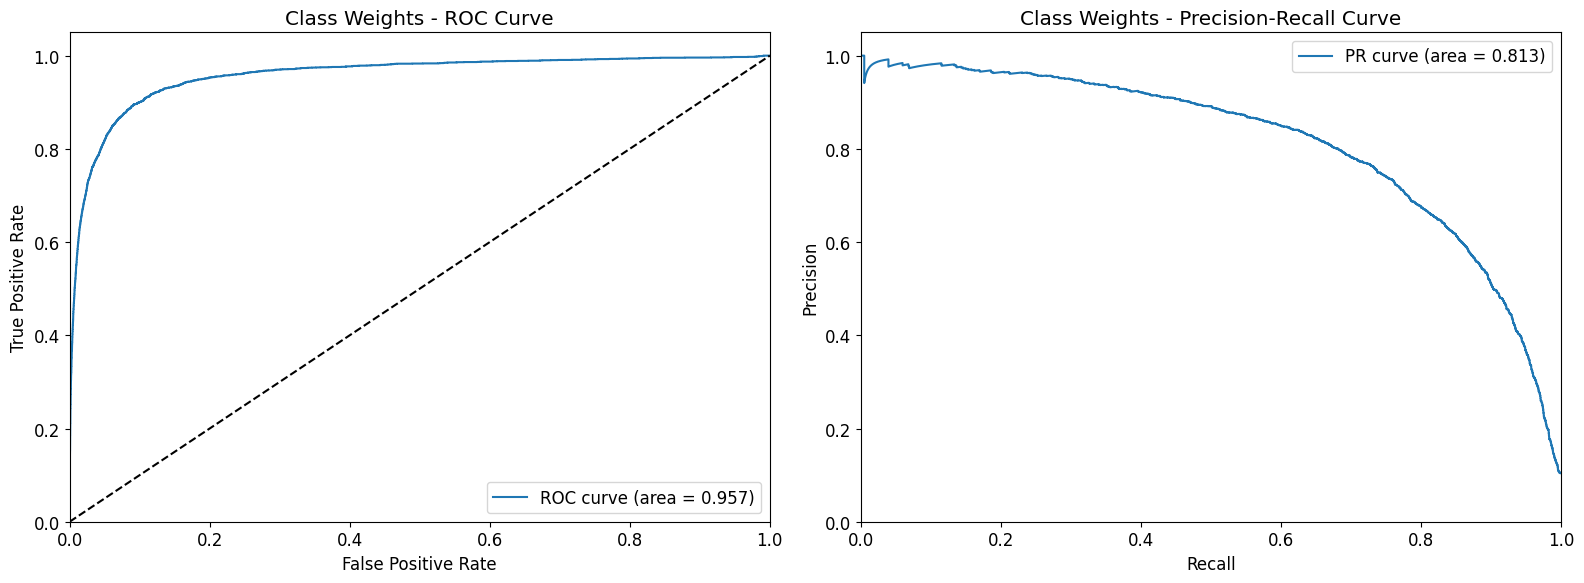

In [8]:
# Train a model with class weights
weighted_model = LogisticRegression(class_weight='balanced', random_state=42)
weighted_results = evaluate_model(weighted_model, X_train, X_test, y_train, y_test, "Class Weights")

### 4.2 Threshold Adjustment

Instead of using the default threshold of 0.5 for classification, we can adjust it to improve performance on the minority class.

Optimal threshold: 0.1306

Threshold Adjustment - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     26877
           1       0.54      0.87      0.67      3123

    accuracy                           0.91     30000
   macro avg       0.76      0.89      0.81     30000
weighted avg       0.94      0.91      0.92     30000



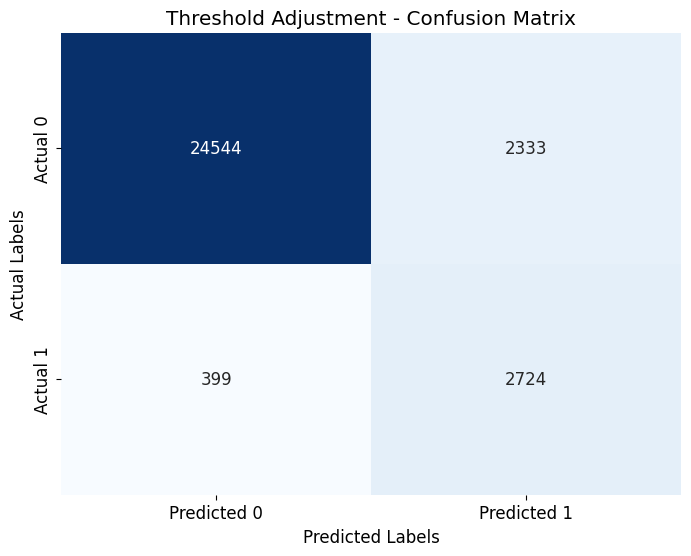

In [9]:
# Train a regular model
threshold_model = LogisticRegression(random_state=42)
threshold_model.fit(X_train, y_train)

# Get probabilities
y_prob = threshold_model.predict_proba(X_test)[:, 1]

# Find the optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Make predictions with the optimal threshold
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
print("\nThreshold Adjustment - Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix with adjusted threshold
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Threshold Adjustment - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## 5. Comparing Results

Let's compare the performance of all the approaches we've tried.

Model Performance Comparison:
                        ROC-AUC    PR-AUC
Baseline (Imbalanced)  0.954352  0.827047
Undersampling          0.957427  0.813415
Class Weights          0.957453  0.813092
Oversampling           0.957515  0.812960
SMOTE                  0.957498  0.811496


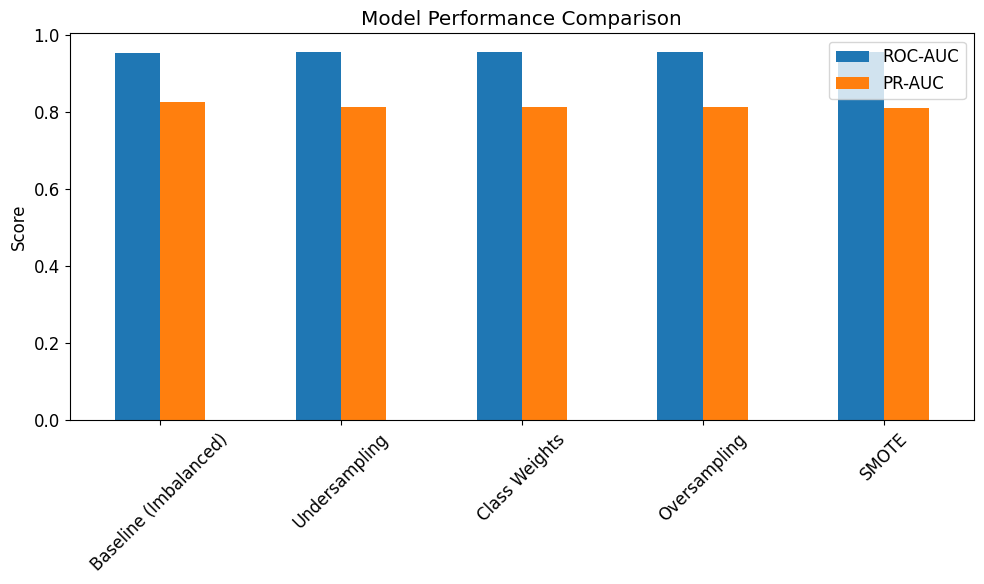

In [10]:
# Collect results
results = {
    'Baseline (Imbalanced)': baseline_results,
    'Undersampling': undersample_results,
    'Oversampling': oversample_results,
    'SMOTE': smote_results,
    'Class Weights': weighted_results,
}

# Compare ROC-AUC and PR-AUC
metrics = {
    'ROC-AUC': [result['roc_auc'] for result in results.values()],
    'PR-AUC': [result['pr_auc'] for result in results.values()]
}

comparison_df = pd.DataFrame(metrics, index=results.keys())
comparison_df = comparison_df.sort_values('PR-AUC', ascending=False)

print("Model Performance Comparison:")
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

There exist several approaches to handle imbalanced datasets (we deep dived only into some of them):

1. **Resampling techniques**:
   - Undersampling (random, NearMiss, Tomek links)
   - Oversampling (random, SMOTE, ADASYN)

2. **Algorithm-level approaches**:
   - Class weighting
   - Threshold adjustment

3. **Ensemble methods**:
   - Balanced Random Forest

### Key Takeaways

- The best approach depends on your specific dataset and requirements
- For small datasets, oversampling is often better than undersampling to avoid information loss
- SMOTE generally performs better than simple random oversampling
- Class weighting is a simple yet effective approach
- Always use appropriate evaluation metrics (PR-AUC, F1-score, etc.) for imbalanced datasets
- Consider the trade-off between precision and recall based on your application needs

### Best Practices

1. Always split your data before applying resampling techniques to avoid data leakage
2. Use stratified sampling to maintain class distribution in train/test splits
3. Try multiple approaches and compare their performance
4. Choose evaluation metrics that align with your business goals
5. Consider the costs of false positives vs. false negatives in your specific application

# 6. Anomaly Detection

## 6.1. What are Anomalies?

Anomalies (also called outliers) are data points that significantly deviate from the majority of the data. They can be caused by:
- Measurement errors
- Natural variation
- Fraudulent activity
- System failures
- Novel patterns or rare events

### Why is Anomaly Detection Important?

- **Fraud detection**: Identifying suspicious transactions
- **Network security**: Detecting intrusions or unusual access patterns
- **Manufacturing**: Quality control and fault detection
- **Medicine**: Identifying unusual patient patterns
- **Data cleaning**: Removing or investigating erroneous values before analysis

In [12]:
from sklearn.datasets import make_blobs

## Creating Synthetic Data

Let's create a dataset with normal points and some obvious anomalies.

In [15]:
# Generate synthetic data with clusters
X_normal, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=42, cluster_std=2)

# Create some obvious anomalies
X_anomalies = np.random.uniform(low=-15, high=15, size=(15, 2))

# Combine normal and anomaly data
X = np.vstack([X_normal, X_anomalies])
labels = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['is_anomaly'] = labels

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (315, 3)


,feature1,feature2,is_anomaly
0,5.316872,1.142594,0.0
1,5.917064,-1.349870,0.0
2,-2.536192,6.898864,0.0
3,5.734074,1.568784,0.0
4,5.219429,6.123971,0.0


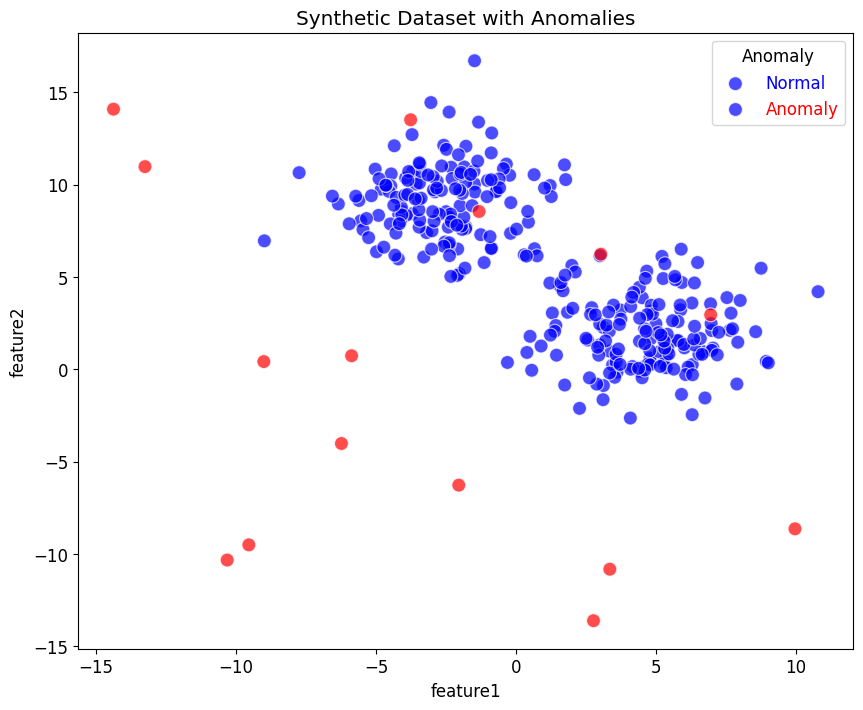

In [54]:
# Visualize the dataset
plt.figure(figsize=(10, 8))
sns.scatterplot(x='feature1', y='feature2', hue='is_anomaly', 
                palette={0: 'blue', 1: 'red'}, 
                data=df, s=100, alpha=0.7)
plt.title('Synthetic Dataset with Anomalies')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'], labelcolor=['blue','red'])

plt.show()

## 6.2. Anomaly Detection Approaches

There are several approaches to anomaly detection:

1. **Supervised**: Uses labeled data with both normal and anomalous examples
2. **Semi-supervised**: Trained only on normal data, then identifies deviations
3. **Unsupervised**: No labels required, identifies patterns that deviate from the majority

In this notebook, we'll focus on unsupervised and semi-supervised methods, as they're more common in real-world scenarios where anomalies are rare and often unlabeled.

## Statistical Methods

### Z-Score Method

One of the simplest approaches is using z-scores (standard deviations from the mean). Points with absolute z-scores greater than a threshold (typically 3) are considered anomalies.

In [26]:
def z_score_detector(data, threshold=2):
    """Detect anomalies using Z-score method"""
    # Calculate z-scores for each feature
    z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        z_scores[column] = (data[column] - data[column].mean()) / data[column].std()
    
    # Find rows where any feature has |z-score| > threshold
    outliers = (z_scores.abs() > threshold).any(axis=1)
    return outliers

# Apply to our dataset (excluding the 'is_anomaly' column)
detected_outliers = z_score_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(df['is_anomaly'], detected_outliers)
precision = precision_score(df['is_anomaly'], detected_outliers)
recall = recall_score(df['is_anomaly'], detected_outliers)
f1 = f1_score(df['is_anomaly'], detected_outliers)

print(f"Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Z-Score Method Performance:
Accuracy: 0.9683
Precision: 0.6923
Recall: 0.6000
F1 Score: 0.6429


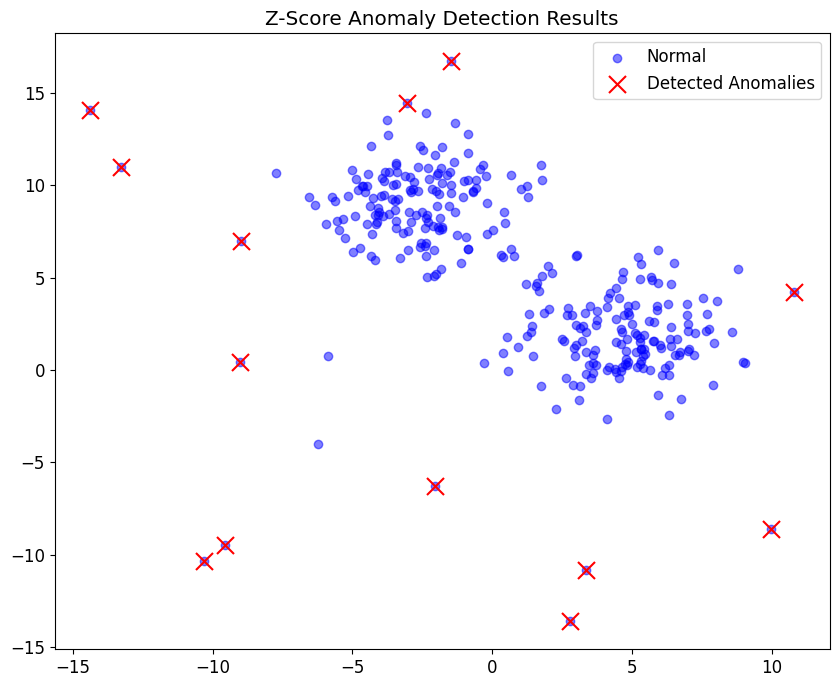

In [27]:
# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[detected_outliers, 'feature1'], df.loc[detected_outliers, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Z-Score Anomaly Detection Results')
plt.legend()
plt.show()

### Modified Z-Score Method

The standard Z-score method can be influenced by the outliers themselves. The modified Z-score uses median and median absolute deviation (MAD) instead of mean and standard deviation.

In [28]:
def modified_z_score_detector(data, threshold=2):
    """Detect anomalies using Modified Z-score method (more robust to outliers)"""
    modified_z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        # Calculate median and MAD
        median_val = data[column].median()
        mad = np.median(np.abs(data[column] - median_val))
        
        # Avoid division by zero
        if mad == 0:
            modified_z_scores[column] = 0
        else:
            # Modified Z-score formula
            modified_z_scores[column] = 0.6745 * (data[column] - median_val) / mad
    
    # Find rows where any feature has |modified z-score| > threshold
    outliers = (modified_z_scores.abs() > threshold).any(axis=1)
    return outliers

# Apply to our dataset
modified_z_detected = modified_z_score_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], modified_z_detected)
precision = precision_score(df['is_anomaly'], modified_z_detected)
recall = recall_score(df['is_anomaly'], modified_z_detected)
f1 = f1_score(df['is_anomaly'], modified_z_detected)

print(f"Modified Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Modified Z-Score Method Performance:
Accuracy: 0.9746
Precision: 0.8889
Recall: 0.5333
F1 Score: 0.6667


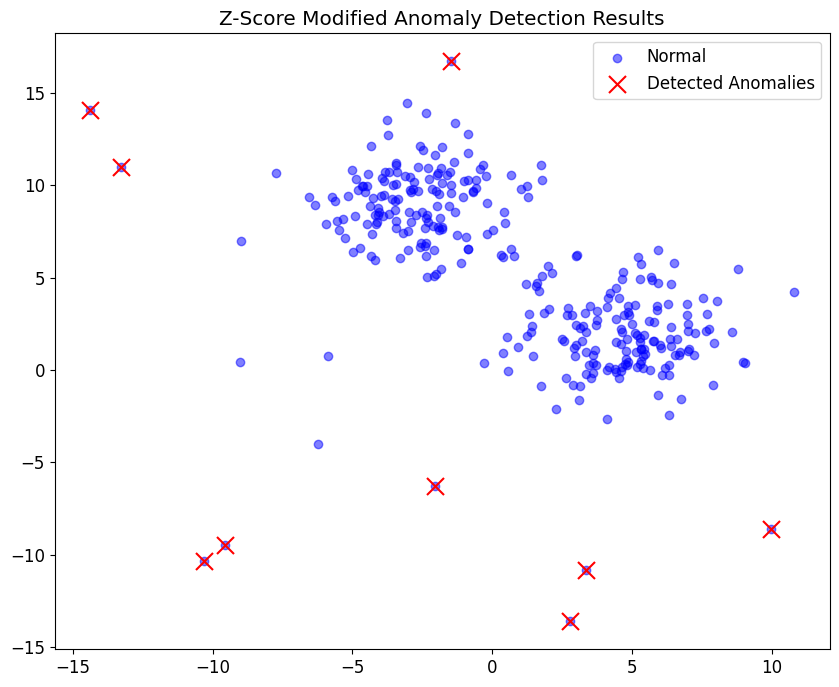

In [29]:
# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[modified_z_detected, 'feature1'], df.loc[modified_z_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Z-Score Modified Anomaly Detection Results')
plt.legend()
plt.show()

### Interquartile Range (IQR) Method

Another statistical approach is using the interquartile range. Points outside Q1 - 1 * IQR or Q3 + 1 * IQR are considered outliers.

In [32]:
def iqr_detector(data, k=1):
    """Detect anomalies using IQR method"""
    outliers_idx = []
    
    for column in data.select_dtypes(include=[np.number]).columns:
        # Calculate Q1, Q3, and IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        # Find outliers for this column
        outliers_current = ((data[column] < lower_bound) | (data[column] > upper_bound))
        outliers_idx.append(outliers_current)
    
    # Combine outliers from all columns (OR operation)
    outliers = pd.DataFrame(outliers_idx).T.any(axis=1)
    return outliers

# Apply to our dataset
iqr_detected = iqr_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], iqr_detected)
precision = precision_score(df['is_anomaly'], iqr_detected)
recall = recall_score(df['is_anomaly'], iqr_detected)
f1 = f1_score(df['is_anomaly'], iqr_detected)

print(f"IQR Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

IQR Method Performance:
Accuracy: 0.9778
Precision: 1.0000
Recall: 0.5333
F1 Score: 0.6957


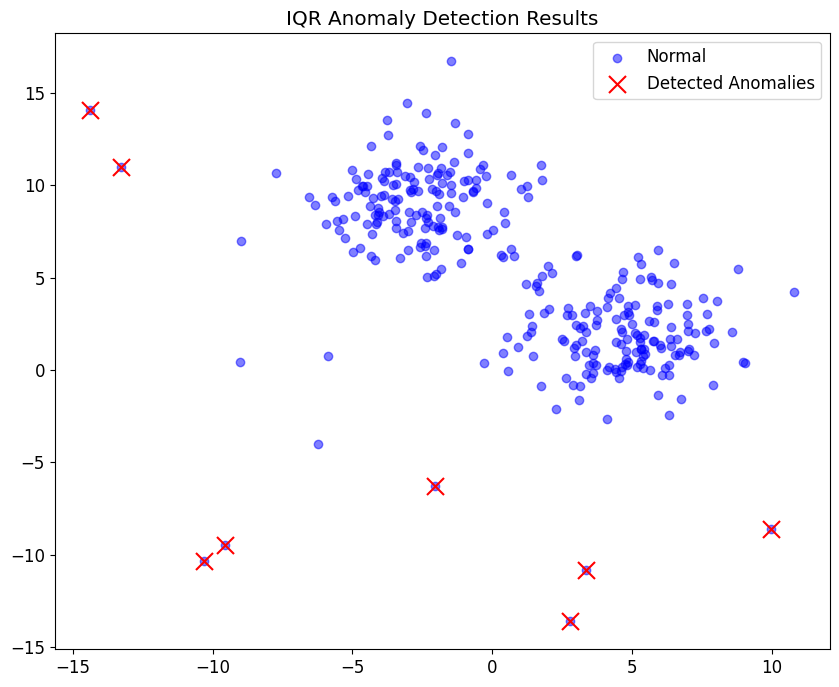

In [33]:
# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[iqr_detected, 'feature1'], df.loc[iqr_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('IQR Anomaly Detection Results')
plt.legend()
plt.show()

## Distance-Based Methods

### K-Nearest Neighbors (KNN) Anomaly Detection

Points with the largest average distance to their k-nearest neighbors are considered anomalies.

In [34]:
from sklearn.neighbors import NearestNeighbors

def knn_detector(data, k=5, contamination=0.05):
    """Detect anomalies using KNN distance"""
    # Initialize and fit the model
    model = NearestNeighbors(n_neighbors=k)
    model.fit(data)
    
    # Get distances to k-nearest neighbors
    distances, _ = model.kneighbors(data)
    
    # Average distance to k neighbors
    avg_distances = distances.mean(axis=1)
    
    # Determine threshold (points with highest distances)
    threshold = np.percentile(avg_distances, 100 * (1 - contamination))
    
    # Identify outliers
    outliers = avg_distances > threshold
    return outliers

# Apply to our dataset
knn_detected = knn_detector(df[['feature1', 'feature2']], contamination=0.05)

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], knn_detected)
precision = precision_score(df['is_anomaly'], knn_detected)
recall = recall_score(df['is_anomaly'], knn_detected)
f1 = f1_score(df['is_anomaly'], knn_detected)

print(f"KNN Anomaly Detection Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

KNN Anomaly Detection Performance:
Accuracy: 0.9714
Precision: 0.6875
Recall: 0.7333
F1 Score: 0.7097


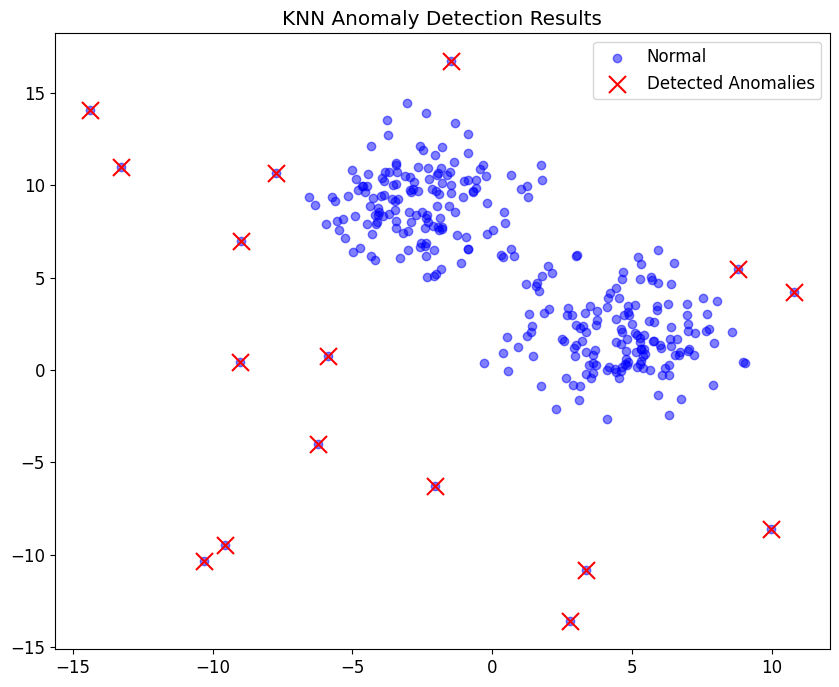

In [35]:
# Visualize the KNN detection results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[knn_detected, 'feature1'], df.loc[knn_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('KNN Anomaly Detection Results')
plt.legend()
plt.show()

## Density-Based Methods

### Local Outlier Factor (LOF)

LOF compares the local density of a point with the densities of its neighbors. Points with substantially lower density than their neighbors are considered anomalies.

In [36]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize and fit the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(df[['feature1', 'feature2']])

# Convert predictions to binary (LOF uses -1 for outliers, 1 for inliers)
lof_detected = y_pred == -1

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], lof_detected)
precision = precision_score(df['is_anomaly'], lof_detected)
recall = recall_score(df['is_anomaly'], lof_detected)
f1 = f1_score(df['is_anomaly'], lof_detected)

print(f"LOF Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

LOF Performance:
Accuracy: 0.9714
Precision: 0.6875
Recall: 0.7333
F1 Score: 0.7097


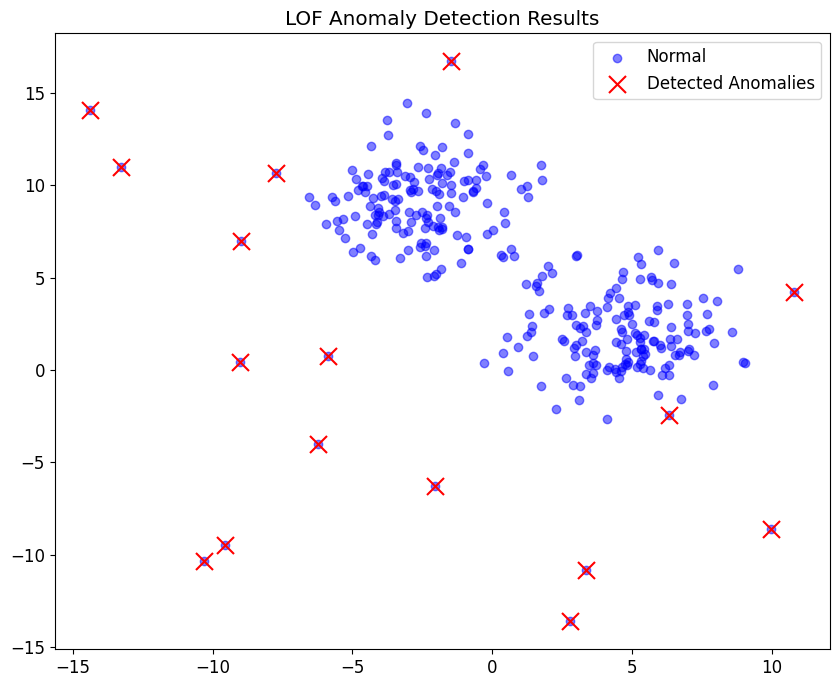

In [37]:
# Visualize the LOF detection results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[lof_detected, 'feature1'], df.loc[lof_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('LOF Anomaly Detection Results')
plt.legend()
plt.show()

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN clusters points based on density. Points that can't be assigned to any cluster are considered anomalies.

In [38]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=5)
clusters = dbscan.fit_predict(df[['feature1', 'feature2']])

# Points labeled as -1 are considered outliers in DBSCAN
dbscan_detected = clusters == -1

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], dbscan_detected)
precision = precision_score(df['is_anomaly'], dbscan_detected)
recall = recall_score(df['is_anomaly'], dbscan_detected)
f1 = f1_score(df['is_anomaly'], dbscan_detected)

print(f"DBSCAN Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

DBSCAN Performance:
Accuracy: 0.9841
Precision: 0.9167
Recall: 0.7333
F1 Score: 0.8148


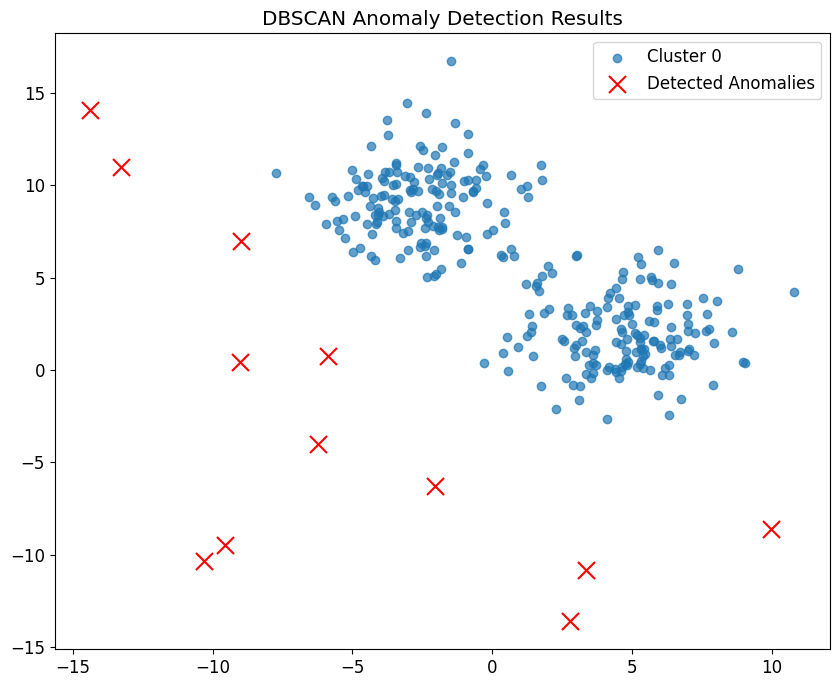

In [39]:
# Visualize the DBSCAN results
plt.figure(figsize=(10, 8))

# Plot normal points colored by cluster
normal_mask = clusters != -1
unique_clusters = np.unique(clusters[normal_mask])
for cluster in unique_clusters:
    cluster_mask = clusters == cluster
    plt.scatter(df.loc[cluster_mask, 'feature1'], df.loc[cluster_mask, 'feature2'], 
                label=f'Cluster {cluster}', alpha=0.7)

# Plot detected outliers
plt.scatter(df.loc[dbscan_detected, 'feature1'], df.loc[dbscan_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')

plt.title('DBSCAN Anomaly Detection Results')
plt.legend()
plt.show()

## Machine Learning Approaches

### Isolation Forest

Isolation Forest isolates observations by randomly selecting a feature and a split value. Anomalies require fewer splits to be isolated, so they end up with shorter paths in the trees.

In [40]:
from sklearn.ensemble import IsolationForest

# Initialize and fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df[['feature1', 'feature2']])

# Predict anomalies
iso_preds = iso_forest.predict(df[['feature1', 'feature2']])
iso_detected = iso_preds == -1  # -1 for outliers, 1 for inliers

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], iso_detected)
precision = precision_score(df['is_anomaly'], iso_detected)
recall = recall_score(df['is_anomaly'], iso_detected)
f1 = f1_score(df['is_anomaly'], iso_detected)

print(f"Isolation Forest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Isolation Forest Performance:
Accuracy: 0.9714
Precision: 0.6875
Recall: 0.7333
F1 Score: 0.7097


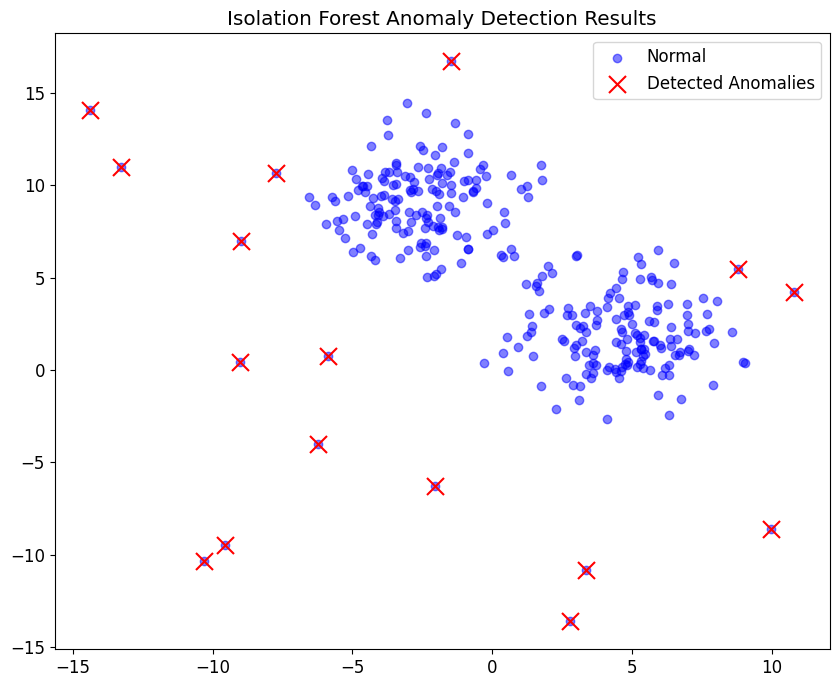

In [41]:
# Visualize the Isolation Forest results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[iso_detected, 'feature1'], df.loc[iso_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Isolation Forest Anomaly Detection Results')
plt.legend()
plt.show()

### One-Class SVM

One-Class SVM learns a boundary that encompasses the normal data. Points outside this boundary are considered anomalies.

In [42]:
from sklearn.svm import OneClassSVM

# Initialize and fit One-Class SVM model
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
ocsvm.fit(df[['feature1', 'feature2']])

# Predict anomalies
ocsvm_preds = ocsvm.predict(df[['feature1', 'feature2']])
ocsvm_detected = ocsvm_preds == -1  # -1 for outliers, 1 for inliers

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], ocsvm_detected)
precision = precision_score(df['is_anomaly'], ocsvm_detected)
recall = recall_score(df['is_anomaly'], ocsvm_detected)
f1 = f1_score(df['is_anomaly'], ocsvm_detected)

print(f"One-Class SVM Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

One-Class SVM Performance:
Accuracy: 0.9238
Precision: 0.3200
Recall: 0.5333
F1 Score: 0.4000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


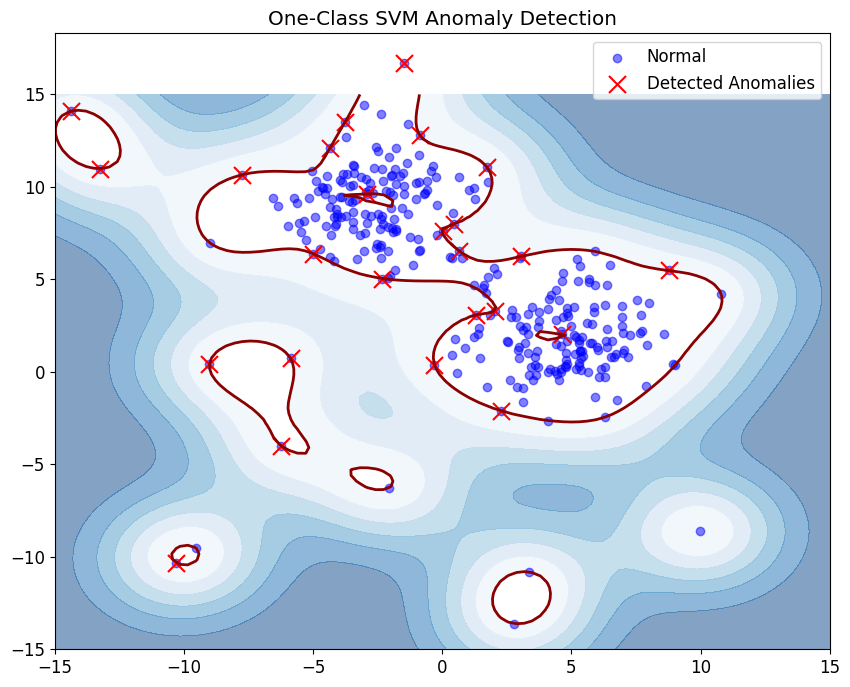

In [43]:
# Visualize One-Class SVM decision boundary
xx, yy = np.meshgrid(np.linspace(-15, 15, 100), np.linspace(-15, 15, 100))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r, alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[ocsvm_detected, 'feature1'], df.loc[ocsvm_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('One-Class SVM Anomaly Detection')
plt.legend()
plt.show()

## Anomalies on Time Series

Anomalies in time series data are observations that deviate significantly from the expected pattern. They can be categorized as:

- **Point Anomalies**: Single data points that are far from the normal range
- **Contextual Anomalies**: Data points that are anomalous in a specific context
- **Collective Anomalies**: A collection of data points that together form an anomaly

Detecting these anomalies is crucial in many applications including:
- System health monitoring
- Fraud detection
- Equipment malfunction prediction
- Network intrusion detection